In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [6]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [7]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed") # Changed to relative path
TRAIN_ZIP = "/content/train-20251104T144001Z-1-001.zip"
VALID_ZIP = "/content/valid-20251104T144000Z-1-001.zip"
TEST_ZIP  = "/content/test-20251104T144137Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting /content/train-20251104T144001Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Found train folder candidate: data_extracted_fixed/train/train
Extracting /content/valid-20251104T144000Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251104T144137Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/train
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/train
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/train -> 4 class folders
Classes: ['no_tumor', 'meningioma', 'glioma', 'pituitary']


In [8]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [9]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [10]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3616 - loss: 1.6852

53/53 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.3634 - loss: 1.6805 - val_accuracy: 0.3207 - val_loss: 1.3447
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.5474 - loss: 1.1929 - val_accuracy: 0.3207 - val_loss: 1.3775
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 375s 7s/step - accuracy: 0.6244 - loss: 1.0262 - val_accuracy: 0.3307 - val_loss: 1.5043
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - accuracy: 0.6101 - loss: 1.0428 - val_accuracy: 0.4124 - val_loss: 1.6200
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - accuracy: 0.6769 - loss: 1.0011 - val_accuracy: 0.5060 - val_loss: 1.6463


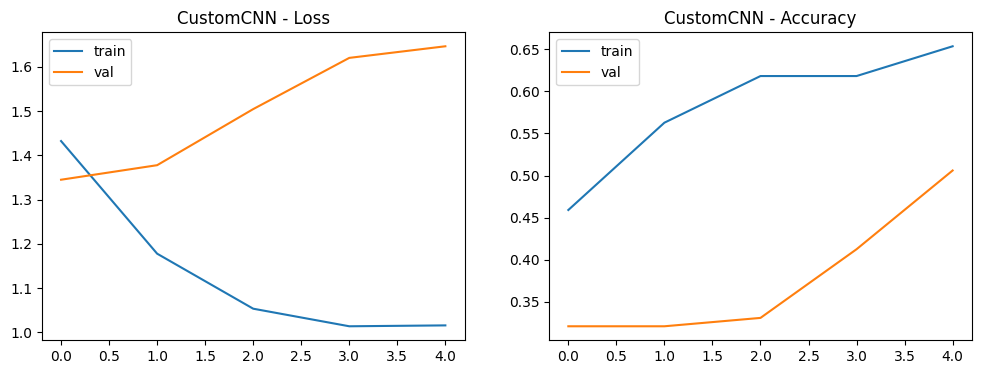


Training ResNet50 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2598 - loss: 1.8337

53/53 ━━━━━━━━━━━━━━━━━━━━ 457s 8s/step - accuracy: 0.2598 - loss: 1.8323 - val_accuracy: 0.3267 - val_loss: 1.4489
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2348 - loss: 1.6221

53/53 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.2354 - loss: 1.6212 - val_accuracy: 0.3247 - val_loss: 1.3702
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2823 - loss: 1.4800

53/53 ━━━━━━━━━━━━━━━━━━━━ 428s 8s/step - accuracy: 0.2825 - loss: 1.4803 - val_accuracy: 0.3207 - val_loss: 1.3579
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2641 - loss: 1.5017

53/53 ━━━━━━━━━━━━━━━━━━━━ 449s 8s/step - accuracy: 0.2644 - loss: 1.5014 - val_accuracy: 0.3367 - val_loss: 1.3477
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2949 - loss: 1.4817

53/53 ━━━━━━━━━━━━━━━━━━━━ 488s 9s/step - accuracy: 0.2950 - loss: 1.4813 - val_accuracy: 0.3406 - val_loss: 1.3363
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3144 - loss: 1.4347

53/53 ━━━━━━━━━━━━━━━━━━━━ 426s 8s/step - accuracy: 0.3144 - loss: 1.4347 - val_accuracy: 0.3606 - val_loss: 1.3231
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2819 - loss: 1.4521

53/53 ━━━━━━━━━━━━━━━━━━━━ 450s 8s/step - accuracy: 0.2822 - loss: 1.4519 - val_accuracy: 0.4004 - val_loss: 1.3145
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3286 - loss: 1.4088

53/53 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.3286 - loss: 1.4087 - val_accuracy: 0.4044 - val_loss: 1.3020
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3033 - loss: 1.4337

53/53 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - accuracy: 0.3036 - loss: 1.4332 - val_accuracy: 0.4323 - val_loss: 1.2942
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3144 - loss: 1.3787

53/53 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.3146 - loss: 1.3786 - val_accuracy: 0.4084 - val_loss: 1.2824
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3728 - loss: 1.3497

53/53 ━━━━━━━━━━━━━━━━━━━━ 478s 9s/step - accuracy: 0.3725 - loss: 1.3499 - val_accuracy: 0.4382 - val_loss: 1.2748
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3363 - loss: 1.3607

53/53 ━━━━━━━━━━━━━━━━━━━━ 432s 8s/step - accuracy: 0.3365 - loss: 1.3607 - val_accuracy: 0.4422 - val_loss: 1.2656
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3709 - loss: 1.3455

53/53 ━━━━━━━━━━━━━━━━━━━━ 432s 8s/step - accuracy: 0.3709 - loss: 1.3455 - val_accuracy: 0.4462 - val_loss: 1.2578
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3669 - loss: 1.3469

53/53 ━━━━━━━━━━━━━━━━━━━━ 481s 9s/step - accuracy: 0.3668 - loss: 1.3470 - val_accuracy: 0.4801 - val_loss: 1.2523
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3856 - loss: 1.3224

53/53 ━━━━━━━━━━━━━━━━━━━━ 483s 9s/step - accuracy: 0.3852 - loss: 1.3226 - val_accuracy: 0.4343 - val_loss: 1.2413


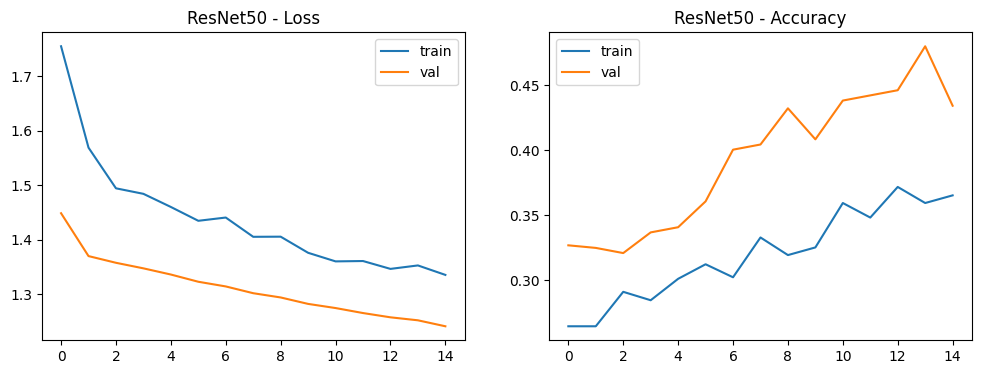


Training MobileNetV2 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2352 - loss: 1.7240

53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.2357 - loss: 1.7223 - val_accuracy: 0.3625 - val_loss: 1.4363
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4193 - loss: 1.3551

53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4194 - loss: 1.3544 - val_accuracy: 0.4880 - val_loss: 1.2269
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4667 - loss: 1.1929

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.4674 - loss: 1.1920 - val_accuracy: 0.5637 - val_loss: 1.0993
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5537 - loss: 1.1081

53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5541 - loss: 1.1070 - val_accuracy: 0.6036 - val_loss: 1.0076
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6016 - loss: 0.9623

53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6018 - loss: 0.9622 - val_accuracy: 0.6195 - val_loss: 0.9525
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6380 - loss: 0.9104

53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6382 - loss: 0.9102 - val_accuracy: 0.6594 - val_loss: 0.9002
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6421 - loss: 0.8714

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6425 - loss: 0.8709 - val_accuracy: 0.6554 - val_loss: 0.8747
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6877 - loss: 0.7851

53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6875 - loss: 0.7856 - val_accuracy: 0.6733 - val_loss: 0.8311
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7140 - loss: 0.7227

53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7137 - loss: 0.7231 - val_accuracy: 0.6773 - val_loss: 0.8156
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7207 - loss: 0.7500

53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7205 - loss: 0.7499 - val_accuracy: 0.6673 - val_loss: 0.7998
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7304 - loss: 0.7169

53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7304 - loss: 0.7170 - val_accuracy: 0.6952 - val_loss: 0.7656
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7267 - loss: 0.7123

53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7269 - loss: 0.7118 - val_accuracy: 0.7052 - val_loss: 0.7495
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7213 - loss: 0.6791 - val_accuracy: 0.6813 - val_loss: 0.7543
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7404 - loss: 0.6740

53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7406 - loss: 0.6735 - val_accuracy: 0.6912 - val_loss: 0.7460
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7425 - loss: 0.6590

53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7425 - loss: 0.6589 - val_accuracy: 0.6992 - val_loss: 0.7266


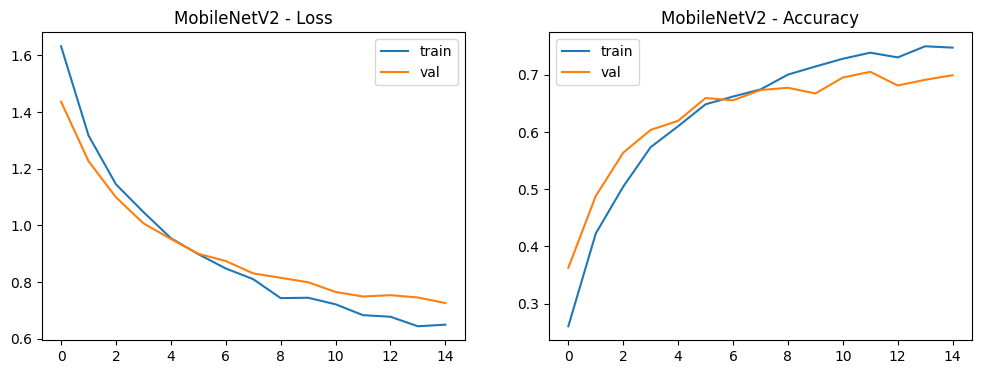


Training InceptionV3 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2803 - loss: 1.6210

53/53 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.2811 - loss: 1.6189 - val_accuracy: 0.4363 - val_loss: 1.2958
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4123 - loss: 1.3459

53/53 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.4129 - loss: 1.3446 - val_accuracy: 0.5458 - val_loss: 1.1111
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5246 - loss: 1.1400

53/53 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 0.5248 - loss: 1.1395 - val_accuracy: 0.5797 - val_loss: 1.0191
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5936 - loss: 1.0440

53/53 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.5934 - loss: 1.0438 - val_accuracy: 0.6235 - val_loss: 0.9264
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5825 - loss: 1.0169

53/53 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.5828 - loss: 1.0162 - val_accuracy: 0.6355 - val_loss: 0.9042
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6189 - loss: 0.9387

53/53 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.6190 - loss: 0.9386 - val_accuracy: 0.6574 - val_loss: 0.8550
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6668 - loss: 0.8345

53/53 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.6668 - loss: 0.8345 - val_accuracy: 0.6873 - val_loss: 0.8196
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6758 - loss: 0.8146

53/53 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.6759 - loss: 0.8143 - val_accuracy: 0.6813 - val_loss: 0.8149
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6898 - loss: 0.8074

53/53 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.6895 - loss: 0.8078 - val_accuracy: 0.7052 - val_loss: 0.7731
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6915 - loss: 0.7820

53/53 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.6914 - loss: 0.7820 - val_accuracy: 0.7112 - val_loss: 0.7417
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.6916 - loss: 0.7679 - val_accuracy: 0.7012 - val_loss: 0.7518
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7224 - loss: 0.7083

53/53 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - accuracy: 0.7223 - loss: 0.7084 - val_accuracy: 0.7371 - val_loss: 0.7054
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.7350 - loss: 0.6848 - val_accuracy: 0.7191 - val_loss: 0.7208
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.7241 - loss: 0.6759 - val_accuracy: 0.7112 - val_loss: 0.7128
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7315 - loss: 0.6720

53/53 ━━━━━━━━━━━━━━━━━━━━ 326s 6s/step - accuracy: 0.7316 - loss: 0.6721 - val_accuracy: 0.7510 - val_loss: 0.6831


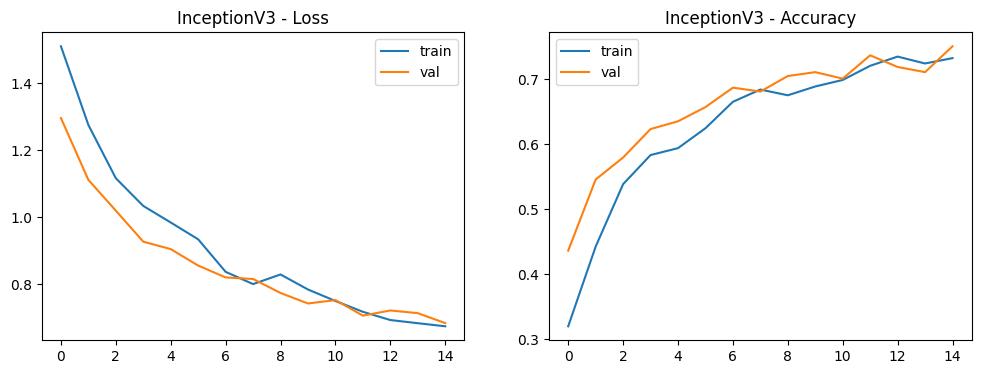

In [11]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1071  Recall=0.3252  F1=0.1611
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.50        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



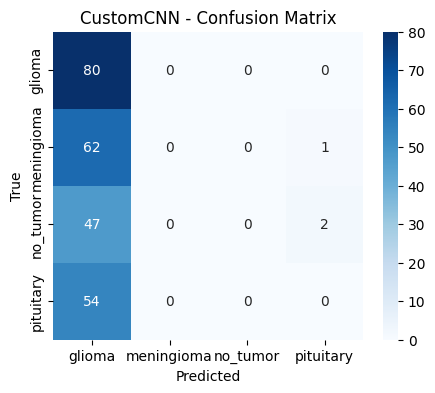


📊 ResNet50 Results:
Accuracy=0.4390  Precision=0.6354  Recall=0.4390  F1=0.3190
              precision    recall  f1-score   support

      glioma       0.39      1.00      0.56        80
  meningioma       1.00      0.02      0.03        63
    no_tumor       0.72      0.53      0.61        49
   pituitary       0.50      0.02      0.04        54

    accuracy                           0.44       246
   macro avg       0.65      0.39      0.31       246
weighted avg       0.64      0.44      0.32       246



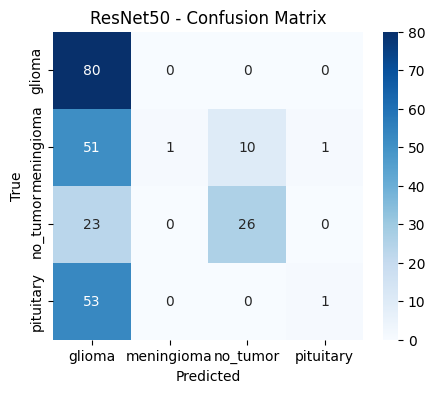


📊 MobileNetV2 Results:
Accuracy=0.7033  Precision=0.7315  Recall=0.7033  F1=0.6845
              precision    recall  f1-score   support

      glioma       0.82      0.86      0.84        80
  meningioma       0.66      0.30      0.41        63
    no_tumor       0.89      0.67      0.77        49
   pituitary       0.54      0.96      0.69        54

    accuracy                           0.70       246
   macro avg       0.73      0.70      0.68       246
weighted avg       0.73      0.70      0.68       246



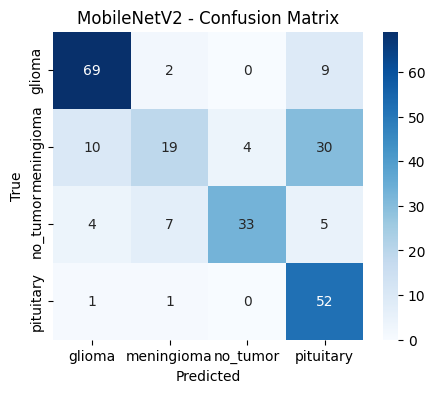


📊 InceptionV3 Results:
Accuracy=0.6829  Precision=0.6852  Recall=0.6829  F1=0.6582
              precision    recall  f1-score   support

      glioma       0.79      0.81      0.80        80
  meningioma       0.59      0.27      0.37        63
    no_tumor       0.76      0.69      0.72        49
   pituitary       0.58      0.96      0.72        54

    accuracy                           0.68       246
   macro avg       0.68      0.68      0.65       246
weighted avg       0.69      0.68      0.66       246



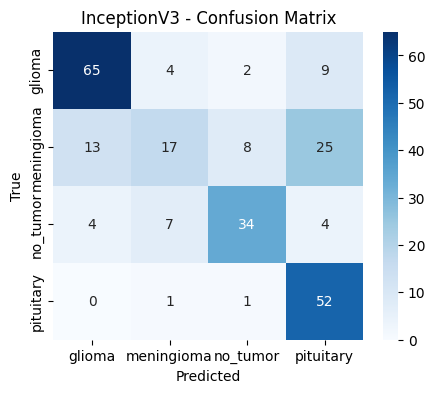

In [12]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
2  MobileNetV2  0.703252   0.731475  0.703252  0.684486
3  InceptionV3  0.682927   0.685235  0.682927  0.658240
1     ResNet50  0.439024   0.635393  0.439024  0.318996
0    CustomCNN  0.325203   0.107063  0.325203  0.161091


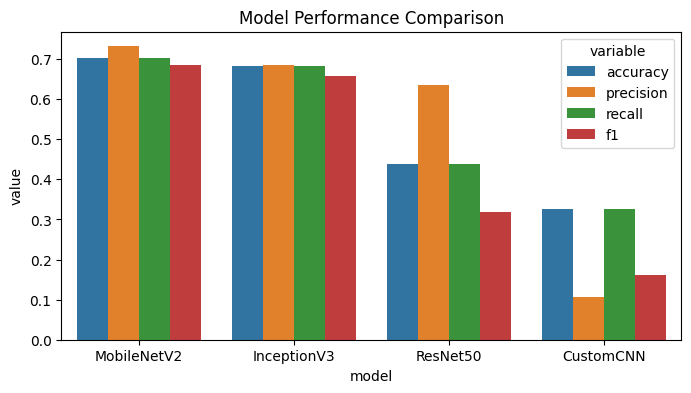


🏆 Best Performing Model: MobileNetV2


In [13]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [14]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/MobileNetV2_best.pkl


In [1]:
%%writefile app.py
# 🧠 Brain Tumor Classification — Streamlit (light enhanced)

import os
import json
import pickle
import numpy as np
import tensorflow as tf
import streamlit as st
from PIL import Image

# -----------------------------
# 🔧 CONFIGURATION
# -----------------------------
st.set_page_config(page_title="Brain Tumor Classifier", page_icon="🧠", layout="centered")

MODEL_PATH = r"D:\Project_6\MobileNetV2_best.pkl"
IMG_SIZE = (224, 224)
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

st.title("🧠 Brain Tumor Classification")
st.write("Upload a **brain MRI image** below to classify the tumor type.")

# -----------------------------
# 🧩 LOAD TRAINED MODEL
# -----------------------------
@st.cache_resource(show_spinner=True)
def load_model(path: str):
    with open(path, "rb") as f:
        m = pickle.load(f)
    return m

with st.sidebar:
    st.header("Model")
    st.caption("Make sure the path is correct and file exists.")
    st.code(MODEL_PATH, language="text")

try:
    assert os.path.exists(MODEL_PATH), f"Model not found at:\n{MODEL_PATH}"
    model = load_model(MODEL_PATH)
    st.sidebar.success("✅ Model loaded successfully!")
except Exception as e:
    st.sidebar.error(f"❌ Model load failed:\n{e}")
    st.stop()

# -----------------------------
# 🔧 HELPERS
# -----------------------------
def preprocess_image(pil_img: Image.Image, target_hw=(224, 224)) -> np.ndarray:
    """PIL -> float32 [1,H,W,C] normalized to [0,1]."""
    arr = np.array(pil_img.convert("RGB"))
    arr = tf.image.resize(arr, target_hw)
    arr = tf.cast(arr, tf.float32) / 255.0
    arr = tf.expand_dims(arr, 0)
    return arr.numpy()

def safe_softmax(vec: np.ndarray) -> np.ndarray:
    x = vec - np.max(vec, axis=-1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=-1, keepdims=True)

# -----------------------------
# 📤 IMAGE UPLOAD SECTION
# -----------------------------
uploaded_file = st.file_uploader("Upload an MRI Image (jpg/png/jpeg)", type=["jpg", "jpeg", "png"])

if not uploaded_file:
    st.info("👆 Please upload a brain MRI image to begin prediction.")
    st.stop()

try:
    image = Image.open(uploaded_file).convert("RGB")
except Exception as e:
    st.error(f"Could not read the image file: {e}")
    st.stop()

st.image(image, caption="🩺 Uploaded MRI Image", use_container_width=True)

# -----------------------------
# 🔮 PREDICT
# -----------------------------
img_batch = preprocess_image(image, IMG_SIZE)

try:
    preds = model.predict(img_batch)
    preds = np.array(preds)
    if preds.ndim == 2 and (preds.min() < 0 or preds.max() > 1):
        preds = safe_softmax(preds)
except Exception as e:
    st.error(f"Prediction failed: {e}")
    st.stop()

if preds.ndim == 1:
    probs = preds
else:
    probs = preds[0]

pred_class = int(np.argmax(probs))
pred_label = CLASS_NAMES[pred_class] if len(CLASS_NAMES) == len(probs) else f"class_{pred_class}"
confidence = float(probs[pred_class])

# -----------------------------
# 🎯 DISPLAY PREDICTION RESULTS
# -----------------------------
st.subheader("🧾 Prediction Results")
st.success(f"**Predicted Tumor Type:** {pred_label}")
st.write(f"**Confidence:** {confidence*100:.2f}%")

st.markdown("### 🔍 Model Confidence per Class")
conf_data = { (CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'class_{i}') : float(probs[i]) for i in range(len(probs)) }
st.bar_chart(conf_data)

result = {
    "predicted_label": pred_label,
    "confidence": confidence,
    "per_class": conf_data,
}
st.download_button("⬇️ Download result (JSON)", data=json.dumps(result, indent=2),
                   file_name="prediction_result.json", mime="application/json")

with st.expander("ℹ️ About this App"):
    st.write("""
This application uses a **deep learning model** trained on brain MRI images
to classify the tumor type into one of four categories:
Glioma
Meningioma
No Tumor
Pituitary Tumor

**Developed by:** Devapriya S  
**Framework:** TensorFlow + Streamlit  
**Model File:** MobileNetV2_best.pkl
""")


Writing app.py


In [10]:
!pip install tensorflow streamlit pillow numpy

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Vijay\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\fault_injection\\fault_injection_service_config_parser.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Vijay\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.3-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached rich-14.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.17.0-cp311-cp311-win_amd64.whl.metadata (34 kB)
  Using cached tensorboard_dat

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Vijay\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\fault_injection\\fault_injection_service_config_parser.h'
HINT: This error might have occurred since 

In [3]:
!pip install streamlit

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.2.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached numpy-2.3.4-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-21.0.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached gitpython-3.1.45-py3-none-any.w

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Vijay\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
os.chdir(r"D:\Project_6")

In [ ]:
!python -m streamlit run app.py
